# Stage 5 — Belief Models

## Purpose

This stage trains **instrumental belief models** — probabilistic estimators that quantify uncertainty about future outcomes. Beliefs are NOT decisions. They are inputs to downstream decision logic.

Four beliefs are estimated for each (player, gameweek) prediction:

| Belief | Interpretation |
|--------|----------------|
| `p_play` | Probability the player gets any minutes |
| `p60` | Probability the player plays 60+ minutes |
| `mu_points` | Expected points given participation |
| `p_haul` | Probability of 10+ points given participation |

This stage does NOT rank players. It does NOT recommend captains. It produces calibrated probability estimates that describe what the model believes about uncertain futures.

The distinction matters: **beliefs describe uncertainty; decisions act on it.**

## Inputs & Outputs

| Item | Description |
|------|-------------|
| **Inputs** | `targets.csv`, `features_participation.csv`, `features_performance.csv` |
| **Outputs** | `storage/datasets/beliefs.csv`, `storage/models/*.pkl` |
| **Produced by** | `dugout.pipeline.belief_models` |
| **Status** | 🔒 Frozen, read-only |

### Model Architecture

| Model | Type | Features | Training Subset |
|-------|------|----------|-----------------|
| `p_play` | LGBMClassifier | participation | all rows |
| `p60` | LGBMClassifier | participation | all rows |
| `mu_points` | LGBMRegressor | performance | y_play==1 only |
| `p_haul` | LGBMClassifier | performance | y_play==1 only |

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load frozen artifacts
beliefs = pd.read_csv("../storage/datasets/beliefs.csv")
targets = pd.read_csv("../storage/datasets/targets.csv")

print(f"Rows: {len(beliefs):,}")
print(f"Players: {beliefs['player_id'].nunique()}")
print(f"Gameweeks: {beliefs['gw'].min()} to {beliefs['gw'].max()}")
beliefs.head()

Rows: 16,559
Players: 799
Gameweeks: 1 to 22


,player_id,gw,p_play,p60,mu_points,p_haul
0,1,1,0.412969,0.273457,NaN,NaN
1,1,2,0.947952,0.900633,2.332592,0.005705
2,1,3,0.947952,0.900633,2.819188,0.009062
3,1,4,0.947952,0.900633,3.881014,0.021244
4,1,5,0.947952,0.900633,3.431279,0.011816


## Structural Sanity Checks

In [2]:
# Row alignment
print(f"Beliefs rows: {len(beliefs):,}")
print(f"Targets rows: {len(targets):,}")
print(f"Match: {len(beliefs) == len(targets)}")

# Coverage
print("\nBelief coverage:")
for col in ["p_play", "p60", "mu_points", "p_haul"]:
    coverage = beliefs[col].notna().mean()
    print(f"  {col}: {coverage:.1%}")

Beliefs rows: 16,559
Targets rows: 16,559
Match: True

Belief coverage:
  p_play: 100.0%
  p60: 100.0%
  mu_points: 55.3%
  p_haul: 55.3%


In [3]:
# Constraint check: p60 <= p_play
violations = (beliefs["p60"] > beliefs["p_play"]).sum()
print(f"p60 > p_play violations: {violations}")

# Probability ranges
print("\nProbability ranges:")
for col in ["p_play", "p60", "p_haul"]:
    valid = beliefs[col].dropna()
    print(f"  {col}: [{valid.min():.4f}, {valid.max():.4f}]")

p60 > p_play violations: 0

Probability ranges:
  p_play: [0.0359, 0.9652]
  p60: [0.0096, 0.9006]
  p_haul: [0.0017, 0.5504]


## Calibration: p_play Reliability Diagram

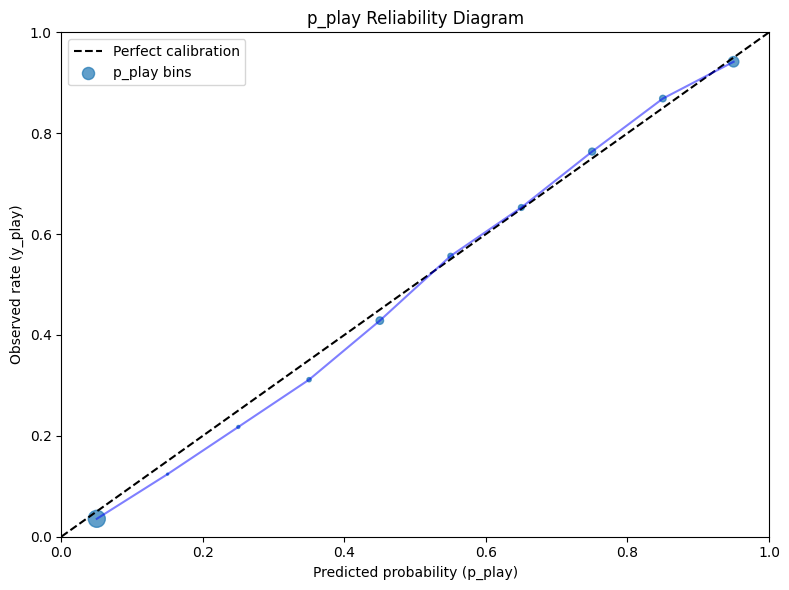

In [4]:
# Merge beliefs with targets for calibration analysis
merged = beliefs.merge(targets[["player_id", "gw", "y_play", "y_60", "y_haul"]], on=["player_id", "gw"])

# Bin predictions and compute observed rates
def reliability_curve(pred, actual, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = []
    observed_rates = []
    counts = []
    
    for i in range(n_bins):
        mask = (pred >= bins[i]) & (pred < bins[i+1])
        if mask.sum() > 0:
            bin_centers.append((bins[i] + bins[i+1]) / 2)
            observed_rates.append(actual[mask].mean())
            counts.append(mask.sum())
    
    return bin_centers, observed_rates, counts

# p_play calibration
centers, observed, counts = reliability_curve(merged["p_play"], merged["y_play"])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
ax.scatter(centers, observed, s=[c/50 for c in counts], alpha=0.7, label="p_play bins")
ax.plot(centers, observed, "b-", alpha=0.5)
ax.set_xlabel("Predicted probability (p_play)")
ax.set_ylabel("Observed rate (y_play)")
ax.set_title("p_play Reliability Diagram")
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## Walk-Forward Validation Summary

The evaluation report (`storage/reports/stage5_belief_models.md`) contains detailed walk-forward metrics. Key findings:

In [5]:
# Load walk-forward validation results from JSON
import json

with open("../storage/reports/walk_forward_results.json", "r") as f:
    validation = json.load(f)

# Compute average metrics per model
def compute_averages(model_name, metric_key):
    """Compute average metric across folds."""
    model_results = validation["models"][model_name]["model"]
    baseline_results = validation["models"][model_name]["baseline"]
    
    model_avg = np.mean([r[metric_key] for r in model_results])
    baseline_avg = np.mean([r[metric_key] for r in baseline_results])
    return model_avg, baseline_avg

# Classification models use log_loss, regression uses MAE (computed from fold data)
p_play_model, p_play_baseline = compute_averages("p_play", "log_loss")
p60_model, p60_baseline = compute_averages("p60", "log_loss")
p_haul_model, p_haul_baseline = compute_averages("p_haul", "log_loss")

# mu_points uses MAE
mu_results = validation["models"]["mu_points"]
mu_points_model = np.mean([r["mae"] for r in mu_results["model"]])
mu_points_baseline = np.mean([r["mae"] for r in mu_results["baseline"]])

metrics = {
    "p_play": {"model": p_play_model, "baseline": p_play_baseline, "type": "Log-Loss"},
    "p60": {"model": p60_model, "baseline": p60_baseline, "type": "Log-Loss"},
    "mu_points": {"model": mu_points_model, "baseline": mu_points_baseline, "type": "MAE"},
    "p_haul": {"model": p_haul_model, "baseline": p_haul_baseline, "type": "Log-Loss"},
}

results = pd.DataFrame([
    {
        "Model": model,
        "Model Metric": round(metrics[model]["model"], 3),
        "Baseline Metric": round(metrics[model]["baseline"], 3),
        "Metric Type": metrics[model]["type"],
        "Model Wins?": f"✅ Yes ({metrics[model]['baseline']/metrics[model]['model']:.1f}×)" 
                       if metrics[model]["model"] < metrics[model]["baseline"] 
                       else "❌ No"
    }
    for model in ["p_play", "p60", "mu_points", "p_haul"]
])

print("Walk-Forward Validation Summary:")
print(results.to_string(index=False))

Walk-Forward Validation Summary:
    Model  Model Metric  Baseline Metric Metric Type  Model Wins?
   p_play         0.324            1.048    Log-Loss ✅ Yes (3.2×)
      p60         0.299            1.000    Log-Loss ✅ Yes (3.3×)
mu_points         2.210            6.600         MAE ✅ Yes (3.0×)
   p_haul         0.200            0.187    Log-Loss         ❌ No


### Fold-by-Fold Performance

Bar charts showing model vs baseline performance across walk-forward validation folds.

In [6]:
# Helper function to plot fold data from JSON
def get_fold_data(model_name, metric_key):
    """Extract fold data for plotting."""
    model_results = validation["models"][model_name]["model"]
    baseline_results = validation["models"][model_name]["baseline"]
    
    folds = []
    for m, b in zip(model_results, baseline_results):
        fold_name = m["model"]  # e.g., "GW 6-8"
        folds.append({
            "fold": fold_name,
            "model": m[metric_key],
            "baseline": b[metric_key]
        })
    return folds

def plot_model_folds(model_name, metric_key, metric_label):
    """Plot fold-by-fold performance for a single model."""
    folds = get_fold_data(model_name, metric_key)
    if not folds:
        print(f"No data for {model_name}")
        return
    
    df = pd.DataFrame(folds)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(df))
    width = 0.35
    
    ax.bar(x - width/2, df['model'], width, label=f'Model ({metric_label})', alpha=0.8)
    ax.bar(x + width/2, df['baseline'], width, label=f'Baseline ({metric_label})', alpha=0.8)
    
    ax.set_xlabel('Fold')
    ax.set_ylabel(metric_label)
    ax.set_title(f'{model_name}: Fold-by-Fold Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(df['fold'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} Fold Data:")
    print(df.to_string(index=False))

#### p_play: Participation Probability

Model performance on predicting whether a player gets any minutes.

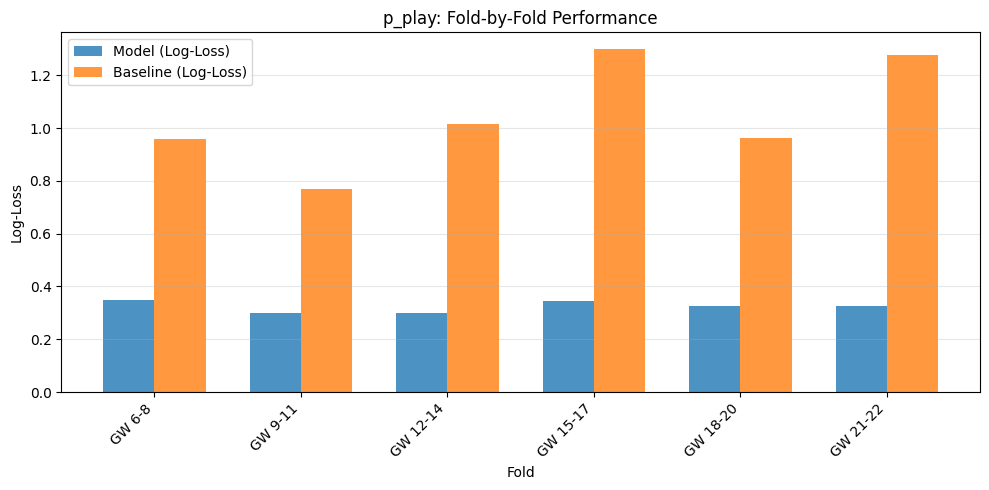


p_play Fold Data:
    fold    model  baseline
  GW 6-8 0.350431  0.959262
 GW 9-11 0.298323  0.769931
GW 12-14 0.298512  1.016268
GW 15-17 0.344399  1.298214
GW 18-20 0.325003  0.964517
GW 21-22 0.326810  1.277478


In [7]:
plot_model_folds("p_play", "log_loss", "Log-Loss")

#### p60: 60+ Minutes Probability

Model performance on predicting whether a player plays 60+ minutes.

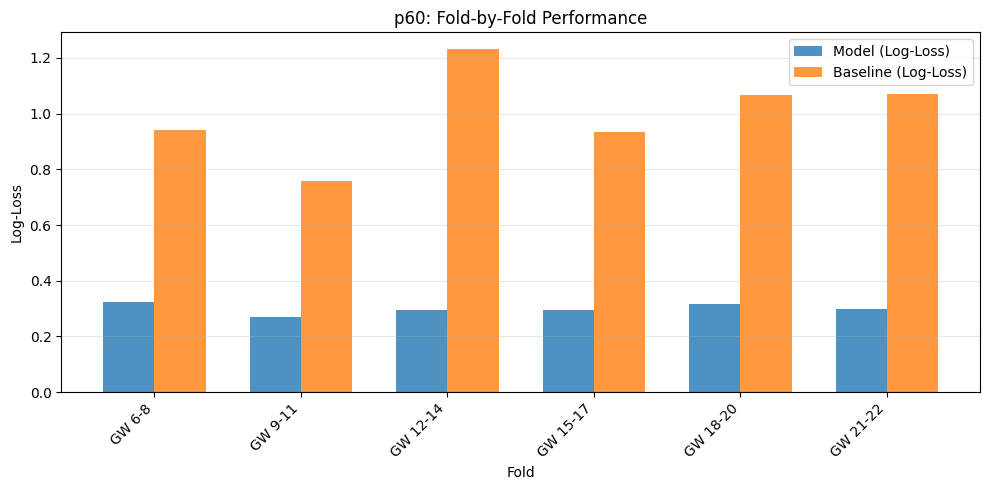


p60 Fold Data:
    fold    model  baseline
  GW 6-8 0.322430  0.942182
 GW 9-11 0.268237  0.757094
GW 12-14 0.294740  1.230591
GW 15-17 0.294735  0.932389
GW 18-20 0.315915  1.066581
GW 21-22 0.298709  1.068929


In [8]:
plot_model_folds("p60", "log_loss", "Log-Loss")

#### mu_points: Expected Points Given Participation

Model performance on predicting expected points for players who played.

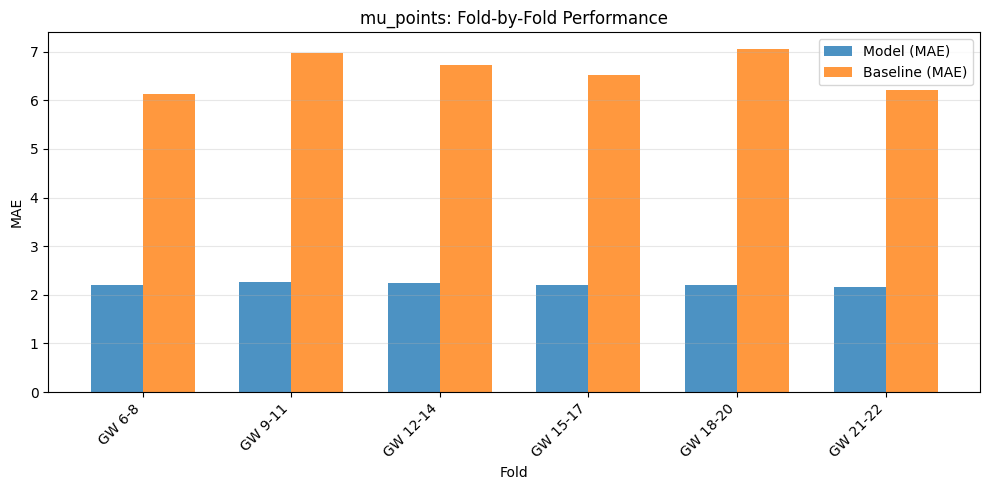


mu_points Fold Data:
    fold    model  baseline
  GW 6-8 2.202499  6.122204
 GW 9-11 2.260468  6.973761
GW 12-14 2.249269  6.731898
GW 15-17 2.198841  6.521681
GW 18-20 2.194846  7.044619
GW 21-22 2.154028  6.203058


In [9]:
plot_model_folds("mu_points", "mae", "MAE")

#### p_haul: Probability of 10+ Points

Model performance on predicting hauls (10+ points) for players who participated.

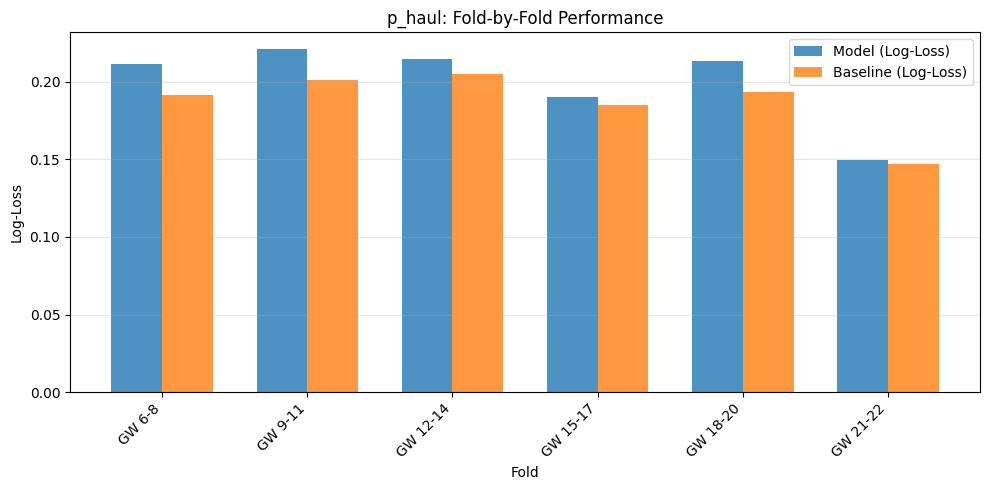


p_haul Fold Data:
    fold    model  baseline
  GW 6-8 0.211708  0.191489
 GW 9-11 0.220952  0.201358
GW 12-14 0.215044  0.204816
GW 15-17 0.190554  0.185077
GW 18-20 0.213268  0.193447
GW 21-22 0.149838  0.146755


In [10]:
plot_model_folds("p_haul", "log_loss", "Log-Loss")

## Interpretation

### Beliefs vs Decisions

This is the most important conceptual distinction:

- **Belief**: "This player has a 75% chance of playing"
- **Decision**: "I should captain this player"

Stage 5 produces beliefs only. Decisions require:
1. Multiple beliefs combined (e.g., $E[\text{points}] = P(\text{play}) \times E[\text{points} | \text{play}]$)
2. Constraints (budget, formation, fixtures)
3. Risk preferences (safe vs differential)

The pipeline stops at beliefs. Decision logic is a separate concern.

### Calibration Over Accuracy

For probability estimates, **calibration** matters more than accuracy:
- A 70% prediction should occur 70% of the time
- It's okay to be uncertain; it's bad to be confidently wrong

The reliability diagram shows how well predictions match observed rates. Points on the diagonal indicate perfect calibration.

### Why p_haul Underperforms Baseline

The `p_haul` model performs slightly worse than the baseline (global haul rate). This is actually informative:

1. **Hauls are rare** (~4.5% of appearances) — very imbalanced
2. **Hauls are noisy** — even elite players haul unpredictably
3. **Participation features don't predict performance quality** — knowing someone plays doesn't tell you they'll score a hat-trick

The baseline (predict global rate for everyone) is hard to beat for rare events. This is a feature, not a bug — it tells us hauls are fundamentally hard to predict from availability features alone.

### Why Baseline Wins Are Informative

When a model underperforms a naive baseline, it means:
1. The features don't contain signal for this target
2. The target is inherently noisy
3. More/better features are needed

For `p_haul`, we would need fixture difficulty, opponent strength, and xG data — features not yet in the pipeline. This informs future work.

### Coverage Asymmetry

- **p_play, p60**: 100% coverage — every row gets a participation belief
- **mu_points, p_haul**: ~55% coverage — conditional on having prior appearances

This is by design. Performance beliefs require performance history. New players with no FPL history get `NaN` for performance beliefs until they appear.

## What This Stage Enables

With calibrated beliefs produced, downstream systems can:

1. **Compute expected points**: $E[\text{pts}] = P(\text{play}) \times \mu_{\text{points}}$
2. **Identify safe picks**: High `p_play`, low variance
3. **Identify differential picks**: Lower `p_play` but high `p_haul`
4. **Inform captain decisions**: Trade off expected value vs upside

**But Stage 5 does not make these decisions.** It provides the probabilistic foundation for decision systems to operate on.

This completes the belief estimation layer. No further stages are authorized in this pipeline specification.